# Process Simulation Solvers

Let's look at two different methods used by process simulators for solving
systems of equations: **sequential modular** and **simulataneous solution**.

The sequential modular method of solving equations solves 
a set of equations as interconnected blocks with inputs and outputs.
The blocks are connected and solved in series. 
Constraints can be matched by iteratively adjusting boundary conditions.

The simulataneous solution method of solving equations
involves constructing a matrix of equations and coefficients,
and iteratively updating the matrix using linear algebra
and a nonlinear solution method such as Newton's.

Both methods are used in very popular
process simulators that are capable of modelling
the same processes. 

We'll look at both of these methods of equation solving
in the context of a wellbore used for water injection.
Water injection is a convenient model because the fluid model
is simple.

For practical reasons we will discretize the model.

<img href="wellbore.png" style="padding: 10px; display: inline-block"/>

The wellbore is vertical with perforations, through
which water flow from the wellbore into the reservoir, at 1000&nbsp;m. 
Wellbore diameter is 6&nbsp;inches, or about 150&nbsp;mm.
The injection rate Q will be fixed at 1500&nbsp;m^3/d, 
reservoir pressure Pres is 125&nbsp;bar, and reservoir permeability is 200&nbsp;mD.

We'll assume constant water density of 980&nbsp;kg/m^3 and 
constant viscosity of 1&nbsp;cP.

There are only a couple of equations needed to define the system:
- The <a href="https://en.wikipedia.org/wiki/Bernoulli%27s_principle">Bernoulli equation</a> to account for hydrostatic head,
- The <a href="https://en.wikipedia.org/wiki/Darcy–Weisbach_equation">Darcy-Weisbach equation</a> for frictional
pressure loss in a pipe,
- and <a href="https://doi.org/10.2118/6893-PA">Peaceman's equation</a> for radial flow in a reservoir block.

## Sequential Modular

We'll define a couple classes to support the sequential modular solution method.

In [1]:
# Gravitational acceleration
g = 9.81  # m/s^2
# Unit conversions from NIST SP 811 https://www.nist.gov/pml/special-publication-811/nist-guide-si-appendix-b-conversion-factors/nist-guide-si-appendix-b9
_MD = 9.869233e-16  # mD -> m^2
_CP = 1e-3  # cP -> Pa*s
_M3_D = 1/86400  # m^3/d -> m^3/s
_BAR = 1e5  # bar -> Pa

class Node:
    """
    Store state of nodes between the equation modules.
    """
    def __init__(self):
        # Internal state stored in SI units
        self.q = 0  # Volumetric flow rate m^3/s
        self.press = 0  # Pressure Pa
        self.dens = 0  # Fluid density kg/m^3
        self.visc = 0  # Fluid viscosity Pa*s
    
    def copy_from(self, other):
        self.q = other.q
        self.press = other.press
        self.dens = other.dens
        self.visc = other.visc

class Module:
    """
    Facilitate connections between equation modules
    """
    def calculate(input: Node, output: Node):
        pass

Now we'll define a couple concrete equation module classes
that define the model

In [2]:
from math import pi, log


class PipeSegment(Module):
    """
    A section of pipe with a particular length, diameter, and roughess
    """
    def __init__(self, length: float = 10, diameter: float = 0.15, roughness: float = 0.025e-3):
        self._length = length  # Pipe section length m
        self._diameter = diameter  # Pipe diameter, m
        self._roughness = roughness  # Pipe roughness, m

    def _friction_factor(Re, roughness, diameter):
        """
        Calculate Darcy friction factor using the Haaland equation
        https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae#Haaland_equation
        """
        C = -1/8*log((roughness/diameter/3.7)**1.11 + 6.9/Re)
        f = 1/C**2
        return f

    def pressure_diff(length, diameter, roughness, q, density, viscosity):
        A = pi*diameter**2/4
        v = q/A
        Re = diameter*v*density/viscosity

        f = PipeSegment._friction_factor(Re, roughness, diameter)
        # Darcy-Weisbach
        dP_friction = -f*length*density/2*v**2/diameter
        # Bernoulli
        dP_fluid = density*g*length
        return dP_friction + dP_fluid
    
    def calculate(self, input: Node, output: Node):
        """
        Calculate output conditions
        Assume that input flow rate is known
        """
        dP = PipeSegment.pressure_diff(self._length, self._diameter, self._roughness, input.q, input.dens, input.visc)

        output.copy_from(input)
        output.press = input.press + dP

class Perforation(Module):
    """
    1-D radial flow in porous media
    """
    _re = 100  # Drainage radius m
    
    def __init__(self, perf_height: float = 10, wellbore_radius: float = 0.15, perm: float = 100*_MD):
        self._perf_height = perf_height
        self._rw = wellbore_radius
        self._perm = perm  # Permeability m^2

    def pressure_diff(permeability, height, reservoir_radius, wellbore_radius, q, viscosity):
        dP = q*viscosity / (2*pi*permeability*height) * log(reservoir_radius/wellbore_radius)
        return dP

    def calculate(self, input: Node, output: Node):
        """
        Calculate reservoir pressure
        Assume input flow rate and pressure are known
        """
        Pwf = input.press  # Sandface pressure Pa
        dP = Perforation.pressure_diff(self._perm, self._perf_height, self._re, self._rw, input.q, input.visc)
        Pres = Pwf - dP

        output.copy_from(input)
        output.press = Pres


We have defined the equation modules, let's connect everything together to define the wellbore model.

In [3]:
# Segment the wellbore into 10 sections of 100 m
modules = [PipeSegment(length=100, diameter=0.15)]*10 + [Perforation(wellbore_radius=0.15, perm=100*_MD)]

# Construct Nodes to store state
# There are 11 wellbore nodes and 1 reservoir node
nodes = [Node() for _ in range(12)]

# Initialize the constraints
# Injection rate is 1500 m^3/d
nodes[0].q = 1500*_M3_D
# Reservoir pressure is 125 bar
# The simple structure we've defined doesn't allow us
# to define the constraint here, it will be enforced when the 
# model equations are solved.

# Initialize properties of injected water
# Water density is 980 kg/m^3, viscosity is 1 cP
nodes[0].dens = 980
nodes[0].visc = 1*_CP

# Provide an estimate of 100 bar for wellhead pressure
nodes[0].press = 100*_BAR

The model is fully defined, now we can solve the model.
As constraints are defined at different nodes in the model,
we will need to solve iteratively to match the constraints.

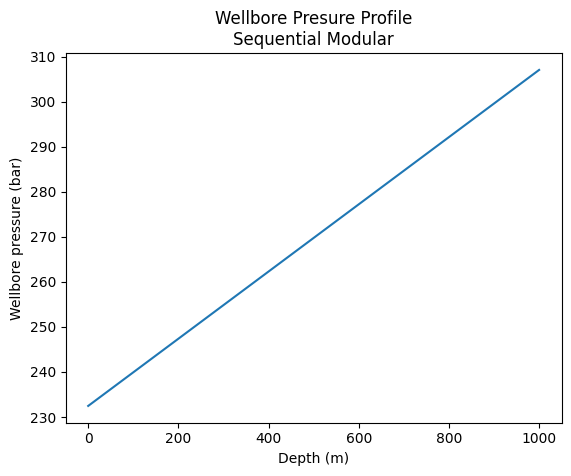

In [4]:
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Define input and output nodes for each of the equation modules
# The output of each node is the input of the next node
inputs = nodes[0:-1]
outputs = nodes[1:]

# Reservoir pressure constraint
Pres = 125*_BAR

# Objective function to solve for wellhead pressure 
# that results in matching reservoir pressure
def f(x):
    # At each iteration we will calculate
    # each of the equation modules in sequence..
    # Hence, sequential modular solution method
    inputs[0].press = x
    for _input, _output, _module in zip(inputs, outputs, modules):
        _module.calculate(_input, _output)
    return outputs[-1].press - Pres

# This outer solution loop around the sequential modular loop
# is equivalent to the use of a recycle operation in 
# a commercial sequential modular process simulator
result = opt.root_scalar(f, method='secant', x0=100*_BAR)
if not result.converged:
    raise Exception("Unconverged")

pressures = [node.press/_BAR for node in nodes[:11]]  # Wellbore pressure profile, Pa -> bar
depths = [x*100 for x in range(11)]

_, ax = plt.subplots()
ax.plot(depths, pressures)
ax.set(xlabel='Depth (m)', ylabel='Wellbore pressure (bar)', title='Wellbore Presure Profile\nSequential Modular')
plt.show()

The wellbore pressure profile is a straight line. This result is expected because the wellbore fluid is incompressible--density is constant so hydrostatic pressure gradient is constant, and velocity is constant so frictional pressure gradient is constant as well.

It would be quite easy at this point to add some calculations for sensitivity analysis or to extend the model with a compressible fluid model.

## Simultaneous Solution

Setting up the simultaneous solution model is somewhat different than 
setting up the simultaneus solution model. The first step is to enumerate
all of the unknowns that will be solved for. 

In the wellbore model, there are 12 nodes: 
11 nodes in the wellbore and one node for the reservoir.
The unknowns for which we will solve 
are the 12 pressures at each node and 11 flow rates between adjacent nodes,
for a total of 23 unknowns. 

We'll number the nodes 0 through 10
from top to bottom of the well, and node 11 for the reservoir.

Solving for 23 unknowns requires 23 equations. 
The equations that define the model are:
<table>
<tr><th>#</th><th>Equation</th></tr>
<tr><td>1</td><td>Q[0] = 1500 m^3/d</td></tr>
<tr><td>2</td><td>P[11] = 125 bar</td></tr>
<tr><td>3..12</td><td>P[n] = P[n-1] + f*L*dens/(2*v^2*d) + dens*g*L   n=1..10</td></tr>
<tr><td>13</td><td>P[10] = P[11] + Q[10]*visc/(2*pi*k*h) * log(re/rw)</td></tr>
<tr><td>14..23</td><td>Q[n] = Q[n-1]   n=1..10</td></tr>
</table>

Now with all the unknowns and equations in hand we can define the 
code to solve the model.

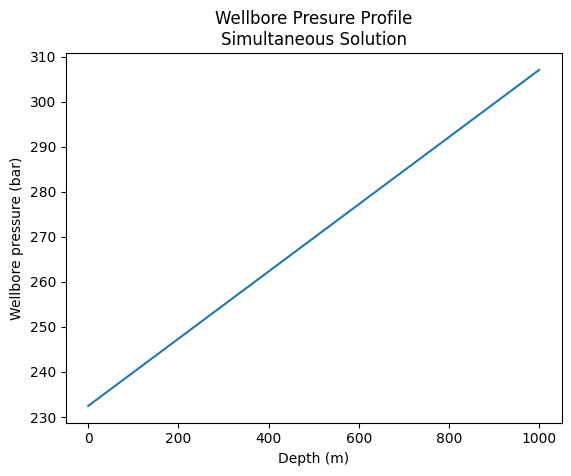

In [5]:
# Hard-code the constant attribute values
# See comments about this below
length = 100
diameter = 0.15
roughness = 0.025e-3
density = 980  # kg/m^3
viscosity = 1*_CP
permeability = 100*_MD
perf_height = 10
reservoir_radius = 100
wellbore_radius = 0.15

# Variable order in the array will be [P_n, Q_n]

def f(x):
    # List slice makes a copy
    # Don't do this in production :)
    P = x[:12]
    Q = x[12:]
    _f = [-1]*len(x)
    _f[0] = P[11] - 125  # 125 bar is the reservoir pressure constraint
    for i in range(10):
        _f[1+i] = P[i+1] - P[i] - PipeSegment.pressure_diff(length, diameter, roughness, Q[i]*_M3_D, density, viscosity)/_BAR
    _f[11] = P[10] - P[11] - Perforation.pressure_diff(permeability, perf_height, reservoir_radius, wellbore_radius, Q[10]*_M3_D, viscosity)/_BAR
    _f[12] = 1500 - Q[0]  # 1500 m^3/d is the injection flow constraint
    for i in range(10):
        _f[13+i] = Q[i] - Q[i+1]
    return _f
    

# Simultaneous solution requires an initial guess
# Note that we're not going to define the variables in SI units
# because the scale of pressure in Pa is many orders of magnitude
# greater than flow in m^3/s
# Scaling is a source of convergence issues in simultaneous solution
x0 = [100]*12 + [1500]*11  # 100 bar, 1500 m^3/d

result = opt.root(f, x0)
if not result['success']:
    raise Exception("Unconverged")

pressures = result['x'][0:11]  # Wellbore pressure profile
depths = [x*100 for x in range(11)]

_, ax = plt.subplots()
ax.plot(depths, pressures)
ax.set(xlabel='Depth (m)', ylabel='Wellbore pressure (bar)', title='Wellbore Presure Profile\nSimultaneous Solution')
plt.show()

Comparing the plots of wellbore pressure for sequential modular and simultaneous solution,
we see that the results are the same.

A comment about the simultaneous solution method:
- We hard-coded a bunch of fluid and equipment attributes at the beginning of the cell.
  This was just a matter of convenience. A proper professional implementation would
  have a framework for defining variables, equations, and constraints, 
  and the equation matrix would be automatically constructed by the framework.
- Simultaneous solution requires an initial guess. A quick internet search
  will confirm that for a complex problem the initial guess can be absolutely
  critical for convergence. Unfortunately, a very good initial guess is also
  very hard and/or very expensive to generate...

## Summary

Although the end result of both sequential modular and simultanous solution are the same,
there are some differences that become apparent in many problems more complex than
the trivial example we've looked at here.

A couple examples of the differences:
- Simultaneous solution tends to be a little better at handling constraints
  in complex models where constraints are defined in mutliple nodes.
  The reason for this is that sequential modular requires recycles when 
  constraints are defined in different nodes, complex models may need
  many recycles, and each recyle potentially requires an iteration loop
- Sequential modular tends to be a little easier when it is necessary to 
  debug problems in the model. For example, if we had modeled a production
  well with compressible fluid instead of an injection well, it's quite easy
  to calculate a negative wellhead pressure needed to produce at a fixed rate.
  Negative physical values tend to cause domain errors in process simulations
  that need to be checked. In a sequential modular model, input can be validated
  in each module. In a simulataneous solution model, input has to be validated
  in the framework that generates the equations.